In [1]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [2]:
import numpy as np
import os
import jax.numpy as jnp
import jax
import pickle
import scipy as sp
from jax import vmap, jit, grad

In [4]:
def net(c, thetas, b, x):
    px = jnp.dot(thetas, x)
    return jnp.dot(c, jnp.clip(px - b, a_min=0)) / jnp.sqrt(b.shape[0])

net = vmap(net, (None, None, None, 0))

def features(thetas, b,  x):
    px = jnp.dot(thetas, x)
    return jnp.clip(px - b, a_min=0) / jnp.sqrt(b.shape[0])

features = vmap(features, (None, None, 0))

def loss(c, thetas, b, x, y, lmbda=0):
    pred = net(c, thetas, b, x)
    return jnp.mean(jnp.log(1. + jnp.exp(-y * pred))) + lmbda * jnp.sum(thetas ** 2)

lossgrads = jit(grad(loss, (0, 1)))

In [5]:
n_total = 100000
n_test = 10000

data_cache = {}
def get_data(seed, d, sigma, s=None):
    key = (seed, d, sigma, s)
    if key in data_cache:
        return data_cache[key]

    np.random.seed(seed)
    y = np.random.randint(2, size=2 * n_total) * 2 - 1
    X = sigma * np.random.randn(2 * n_total, d)
    X[:,0] += y
#     y = fstar(X, s=s) + sigma * np.random.randn(2 * n_total)
    data_cache[key] = (X, y)
    return X, y

In [12]:
d = 10
ntr = 5000
N = 1000
# N = 10 * int(np.sqrt(ntr))
lmbda = 0.01
step = 1.
# tau = config['tau']
X, y = get_data(42, d, sigma=0.5)
# s = config.get('s', 1)

eval_delta = 100

assert ntr + n_test <= n_total
Xtr, Xte = X[:ntr], X[n_total-10000:n_total]
ytr, yte = y[:ntr], y[n_total-10000:n_total]

Xtune = X[n_total:n_total+ntr]
ytune = y[n_total:n_total+ntr]

thetas = np.random.randn(N, d)
# theta /= np.linalg.norm(theta)
# c = np.random.randn(N) / np.sqrt(N)
c = np.random.randn(N)
c = (np.random.randint(2, size=N) * 2 - 1).astype(np.float32)
# b = tau * np.random.randn(N)
b = np.zeros(N)


all_ms = []
test_losses = []
for it in range(501):
    if eval_delta > 0 and it % eval_delta == 0:
        testpreds = net(c, thetas, b, Xte)
        testacc = np.mean(yte * testpreds > 0)
        print(it, testacc)
        all_ms.append(thetas[:,0])
        test_losses.append(testacc)

    gc, gth = lossgrads(c, thetas, b, Xtr, ytr, lmbda)
    # if it < 10000:
    thetas -= step * gth
#     c -= 0.001 * step * gc


0 0.44869998
100 0.9759
200 0.9763
300 0.9765
400 0.9762
500 0.9754


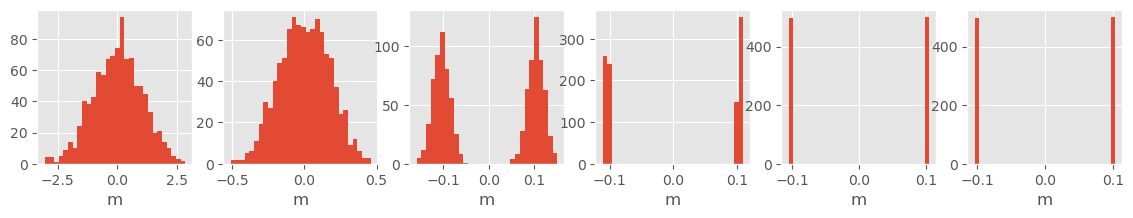

In [13]:
plt.figure(figsize=(14, 2))
for i, ms in enumerate(all_ms):
#     plt.figure(figsize=(3, 2))
    plt.subplot(1, len(all_ms), i+1)
    plt.hist(ms, bins=30)
    plt.xlabel('m')

In [48]:
plt.hist?